In [94]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

from pathlib import Path
import json
import pickle
from utils import load_arguments, get_boxed_answer
from latex_formater import get_final_answer, process_docs, process_results, is_equiv
# from model_generate import load_datasets, prompt_generator, load_model
# from blocks import Batch, Block
import itertools
from tqdm import tqdm
import pandas as pd

root_dir = Path('~/model_evals').expanduser()

# load the name maps
with open('name_maps.json', 'r') as f:
    name_maps = json.load(f)
    DATASET_MAP = name_maps['DATASET_MAP']
    MODEL_MAP = name_maps['MODEL_MAP']

In [14]:
def load_predictions(path):
    print(path)
    if not (path / 'output.json').exists():
        print(f'No output.json in {path}')
        return []
    with open(path / 'output.json', 'r') as f:
        return json.load(f)


raw_predictions = pd.DataFrame([
    {
        'dataset': dataset.name,
        'model': model.name,
        'method': method.name,
        'prediction': prediction,
        'i': i,
        'generation_args': load_arguments(method / 'args.json')
    }
    for dataset in tqdm(list(root_dir.iterdir())[:1])
    for model in dataset.iterdir()
    for method in model.iterdir()
    for i, prediction in enumerate(load_predictions(method))
])
args = raw_predictions.iloc[0]['generation_args']

  0%|                                                                                                  | 0/1 [00:00<?, ?it/s]

/lfs/skampere1/0/kaif/model_evals/Counting_and_Probability_test/Mixtral-8x22b-Instruct-v0.1/teacher_forcing
/lfs/skampere1/0/kaif/model_evals/Counting_and_Probability_test/Gemma-1.1-7b-Instruct/teacher_forcing
/lfs/skampere1/0/kaif/model_evals/Counting_and_Probability_test/Gemma-1.1-7b-Instruct/autoregressive
/lfs/skampere1/0/kaif/model_evals/Counting_and_Probability_test/LLeMMA-34b/teacher_forcing
/lfs/skampere1/0/kaif/model_evals/Counting_and_Probability_test/Abel-7b/teacher_forcing
/lfs/skampere1/0/kaif/model_evals/Counting_and_Probability_test/Abel-7b/autoregressive
/lfs/skampere1/0/kaif/model_evals/Counting_and_Probability_test/Llama-2-13b/teacher_forcing
/lfs/skampere1/0/kaif/model_evals/Counting_and_Probability_test/Llama-2-13b/autoregressive
/lfs/skampere1/0/kaif/model_evals/Counting_and_Probability_test/LLeMMA-7b/teacher_forcing
/lfs/skampere1/0/kaif/model_evals/Counting_and_Probability_test/LLeMMA-7b/autoregressive
/lfs/skampere1/0/kaif/model_evals/Counting_and_Probability_te

100%|██████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]

/lfs/skampere1/0/kaif/model_evals/Counting_and_Probability_test/Deepseek-7b-RL/autoregressive
/lfs/skampere1/0/kaif/model_evals/Counting_and_Probability_test/Meta-Llama-3-70b-Instruct/teacher_forcing
/lfs/skampere1/0/kaif/model_evals/Counting_and_Probability_test/Meta-Llama-3-70b-Instruct/autoregressive


In [16]:
tf_models = set(raw_predictions.query('method == "teacher_forcing"')['model'].unique())
ar_models = set(raw_predictions.query('method == "autoregressive"')['model'].unique())

print(tf_models - ar_models)
print(ar_models - tf_models)

{'Mixtral-8x22b-v0.1', 'Mixtral-8x22b-Instruct-v0.1', 'LLeMMA-34b'}
set()


In [17]:
predictions = raw_predictions.query('method == "teacher_forcing"')
(len(predictions), len(raw_predictions))

(8058, 14694)

In [8]:
len(predictions['prediction'].iloc[3]['chosen_log_probs'])

159

/tmp/user/21882/ipykernel_4185487/3448453564.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample = predictions.groupby(['dataset', 'model', 'method']).apply(lambda x: x.sample(1)).reset_index(drop=True)
/lfs/ampere8/0/kaif/miniforge/envs/TheoremSense2/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/lfs/ampere8/0/kaif/miniforge/envs/TheoremSense2/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version.

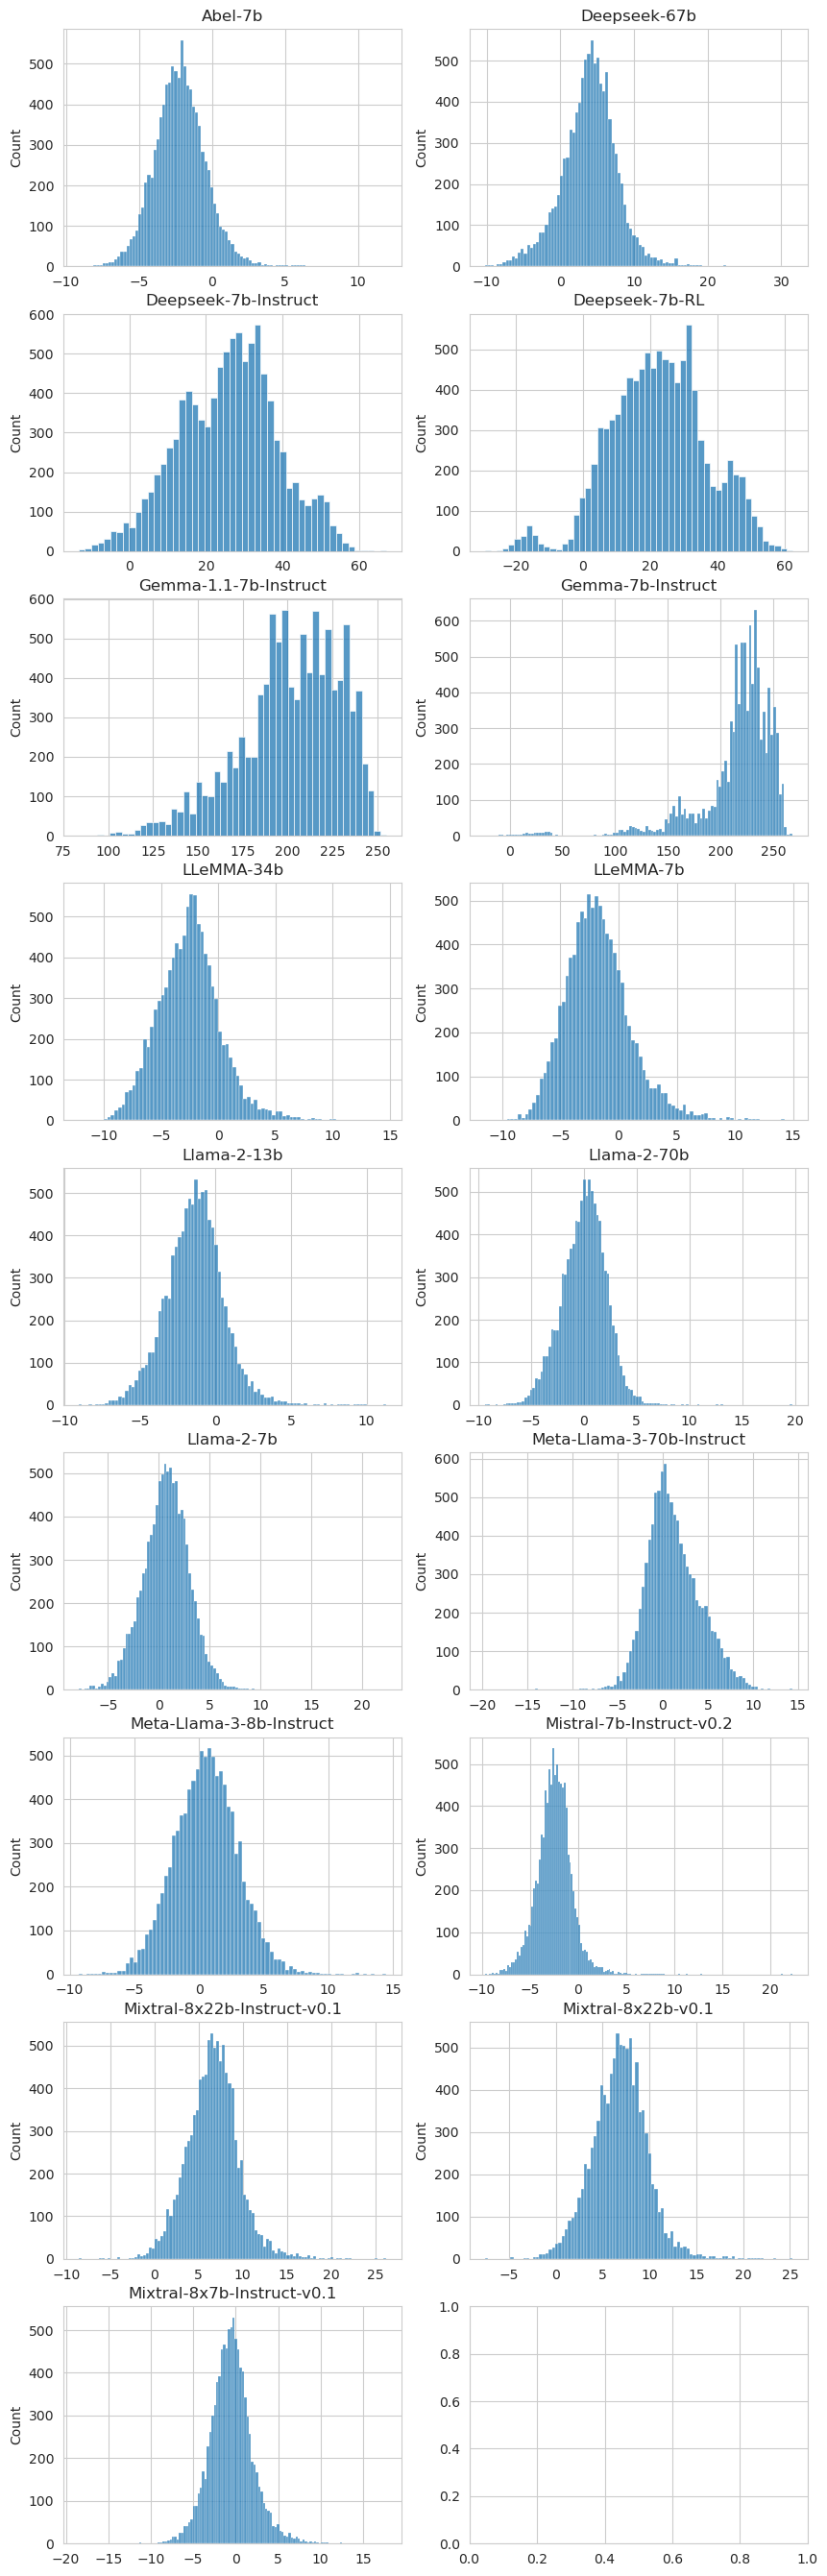

In [20]:
# plot distribution of logits for each model
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# take sample of predictions for each model
sample = predictions.groupby(['dataset', 'model', 'method']).apply(lambda x: x.sample(1)).reset_index(drop=True)
sample['logits'] = sample['prediction'].apply(lambda x: x['raw']['teacher_forced_logits'])
sample['solution_ids'] = sample['prediction'].apply(lambda x: x['raw']['solution_ids'])

# plot the logits
num_models = sample['model'].nunique()
fig, axes = plt.subplots(num_models // 2 + 1, 2, figsize=(10, num_models * 2))
for i, (model, group) in enumerate(sample.groupby('model')):
    ax = axes[i // 2, i % 2]
    logits = np.concatenate(group['logits'].values).flatten()
    # sample
    logits2 = np.random.choice(logits, 10000)
    sns.histplot(logits2, ax=ax)
    ax.set_title(model)
plt.show()

In [95]:
# plot distribution of logits for each model and prediction i and word w
i = 0
w = 0
# select where i = i
sample = predictions.groupby(['dataset', 'model', 'method']).apply(lambda x: x.iloc[i]).reset_index(drop=True)
sample['logits'] = sample['prediction'].apply(lambda x: x['raw']['teacher_forced_logits'])
sample['solution_ids'] = sample['prediction'].apply(lambda x: x['raw']['solution_ids'])
# compute average logits for top k words
sample['word_logits'] = sample['logits'].apply(lambda x: np.mean(np.sort(x, axis=1), axis=0))

# plot the logits
num_models = sample['model'].nunique()
# fig, axes = plt.subplots(num_models // 2 + 1, 2, figsize=(10, num_models * 2))
plt.figure(figsize=(10, 10))
for i, (model, group) in enumerate(sample.groupby('model')):
    # ax = axes[i // 2, i % 2]
    logits = group['word_logits'].values[0]
    # subtract mean
    logits = logits - logits.mean()
    # ax.set_title(model)
    # sort logits
    logits = np.sort(logits)[::-1][:50]
    plt.plot(np.linspace(0, 1, len(logits)), logits, label=f'{len(logits) // 1000}k {model}', marker=['o', 'x', 's', 'v'][i % 4])
plt.legend()
plt.show()

/tmp/user/21882/ipykernel_4185487/86457622.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample = predictions.groupby(['dataset', 'model', 'method']).apply(lambda x: x.iloc[i]).reset_index(drop=True)


TypeError: string indices must be integers

In [97]:
predictions['prediction'].iloc[0]

{'tfa': 0.7333333492279053,
 'tfce': 1.1034737825393677,
 'perpelexity': 3.014619990316225,
 'sumCE': 66.20842742919922,
 'bpc': 0.776573739163923,
 'total_num_tokens': 799,
 'prompt_num_tokens': 739,
 'solution_num_tokens': 60,
 'total_num_chars': 2039,
 'prompt_num_chars': 1916,
 'solution_num_chars': 123,
 'raw': {'teacher_forced_ids': tensor([ 2324,  1407,   302,   272,  1407,  9720,  2078,  1655, 28751, 28724,
          28774, 28734,  1400, 28774, 28733, 28787, 11241,  1655, 28751, 28750,
           1715,   579,   272, 20999, 28751, 28729, 28733, 28740,  1400, 28740,
          28774, 28733, 28774, 11241,  1655, 28740, 28750,  1715,   690,   429,
          28729, 28746, 28740,  2568,  1655, 28740, 28740,  1400,  1400, 28750,
           5070,   304,   429, 28729,  2568,  2858,   286, 28751, 28784,  5124]),
  'solution_ids': tensor([ 1014, 20912,   302,   272,  1407,   349,   878,  1655, 28751, 28740,
          28733, 28734,  1400, 28774, 28733, 28787, 11241,  1655, 28740, 28750,
   

In [104]:
predictions['method'].unique()

array(['teacher_forcing', 'autoregressive'], dtype=object)

In [20]:
predictions['prediction'].iloc[0]

{'tfa': 0.8358209133148193,
 'tfce': 0.5260471105575562,
 'perpelexity': 1.6922298727536849,
 'sumCE': 35.245155334472656,
 'bpc': 0.22400004764936077,
 'total_num_tokens': 799,
 'prompt_num_tokens': 732,
 'solution_num_tokens': 67,
 'total_num_chars': 2194,
 'prompt_num_chars': 1967,
 'solution_num_chars': 227,
 'chosen_log_probs': [-5.648570537567139,
  -3.618560552597046,
  -0.3320765197277069,
  -0.022470036521553993,
  -1.329003930091858,
  -0.08465363830327988,
  -0.10349930822849274,
  -0.14240486919879913,
  -0.0775102898478508,
  -0.877909779548645,
  -0.34337279200553894,
  -0.28080087900161743,
  -1.4100499153137207,
  -0.0034277038648724556,
  -0.46382468938827515,
  -1.216525673866272,
  -0.5467263460159302,
  -0.005568113178014755,
  -1.5361945629119873,
  -0.0004049911512993276,
  -0.5431351065635681,
  -0.046121153980493546,
  -0.0030220337212085724,
  -4.2657318115234375,
  -2.1433629989624023,
  -0.044457193464040756,
  -3.158996332786046e-05,
  -0.21081602573394775,


In [37]:
predictions[predictions['prediction'].apply(lambda x: len(x['chosen_log_probs'])) == 0].iloc[2]

dataset                                Counting_and_Probability_test
model                                                        Abel-7b
method                                               teacher_forcing
prediction         {'tfa': nan, 'tfce': nan, 'perpelexity': nan, ...
i                                                                 74
generation_args    Namespace(debug=False, seed=None, model='GAIR/...
min_k_score                                                      NaN
Name: 1970, dtype: object

In [47]:
# compute min-k score to detect overfitting
# The MIN-K% PROB approach selects the k% tokens in a given example with minimum
# probabilities, if the average probability of these tokens is high, then the example is likely to
# be present in the pretraining data. We define the MIN-K% Score to be the average negative
# log-likelihood of these selected tokens
k = 30
from torch.nn.functional import log_softmax, softmax
import torch
import numpy as np
# compute log probs


# predictions['log_probs'] = predictions['prediction'].apply(lambda x: log_softmax(x['raw']['teacher_forced_logits'], dim=1))
# 
# # get log probs of chosen tokens in the sequence each log_prob is of shape (seq_len, vocab_size)
# # result should be of shape (seq_len,)
# def get_chosen_log_probs(log_probs, solution_ids):
#     return torch.gather(log_probs, 1, solution_ids.unsqueeze(1)).squeeze(1)
# predictions['chosen_log_probs'] = predictions.apply(lambda x: get_chosen_log_probs(x['log_probs'], x['prediction']['raw']['solution_ids']), axis=1)

# compute min-k score
predictions['min_k_score'] = predictions['prediction'].apply(lambda x: -np.sort(x['chosen_log_probs'])[:k].mean())

/tmp/user/21882/ipykernel_764196/341979945.py:22: RuntimeWarning: Mean of empty slice.
  predictions['min_k_score'] = predictions['prediction'].apply(lambda x: -np.sort(x['chosen_log_probs'])[:k].mean())
/lfs/skampere1/0/kaif/conda/envs/TheoremSense/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/user/21882/ipykernel_764196/341979945.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['min_k_score'] = predictions['prediction'].apply(lambda x: -np.sort(x['chosen_log_probs'])[:k].mean())


/lfs/skampere1/0/kaif/conda/envs/TheoremSense/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/lfs/skampere1/0/kaif/conda/envs/TheoremSense/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/lfs/skampere1/0/kaif/conda/envs/TheoremSense/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/lfs/skampere1/0/kaif/conda/envs/TheoremSense/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: Futur

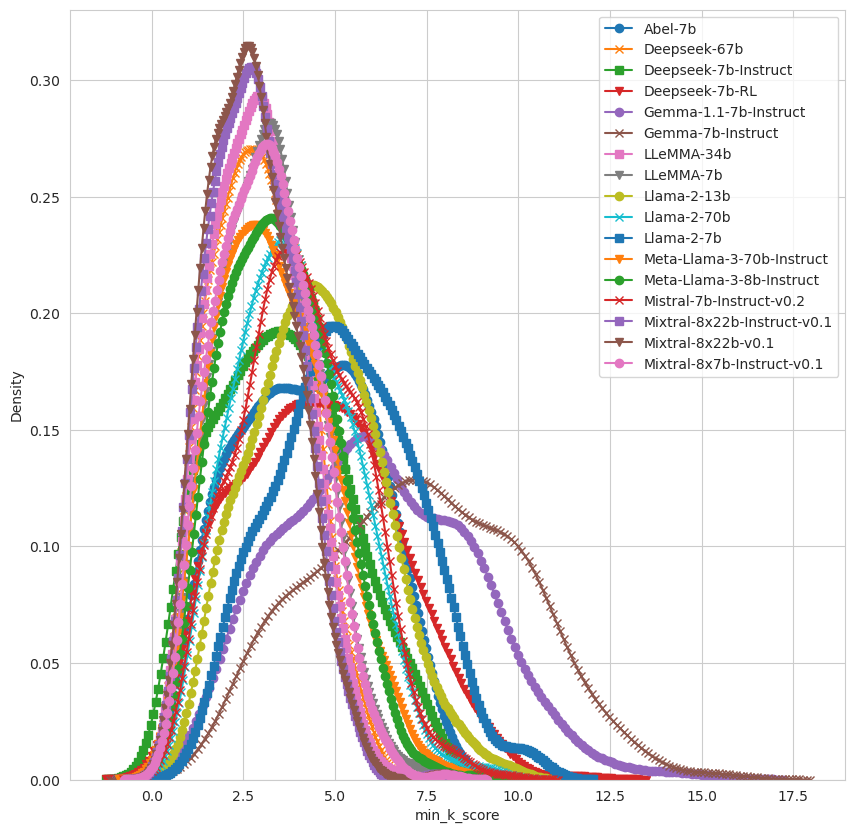

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# plot min-k score
plt.figure(figsize=(10, 10))
for i, (model, group) in enumerate(predictions.groupby('model')):
    # plt.hist(group['min_k_score'], alpha=0.5, label=model)
    # plot as density
    sns.kdeplot(group['min_k_score'], label=model, marker=['o', 'x', 's', 'v'][i % 4])
plt.legend()
plt.show()

In [70]:
predictions['prediction'].iloc[0]['raw']['solution_ids'].shape, predictions['log_probs'].iloc[0].shape

(torch.Size([60, 1]), torch.Size([60, 32000]))

In [80]:
predictions['chosen_log_probs'].iloc[0].shape

torch.Size([60])